# OscGenProcess.py Output Graphical Analysis
The below code section graphs the output data from the python oscillator version. Both python and c++ version of oscillators are tested in this script for future performance comparisons. 

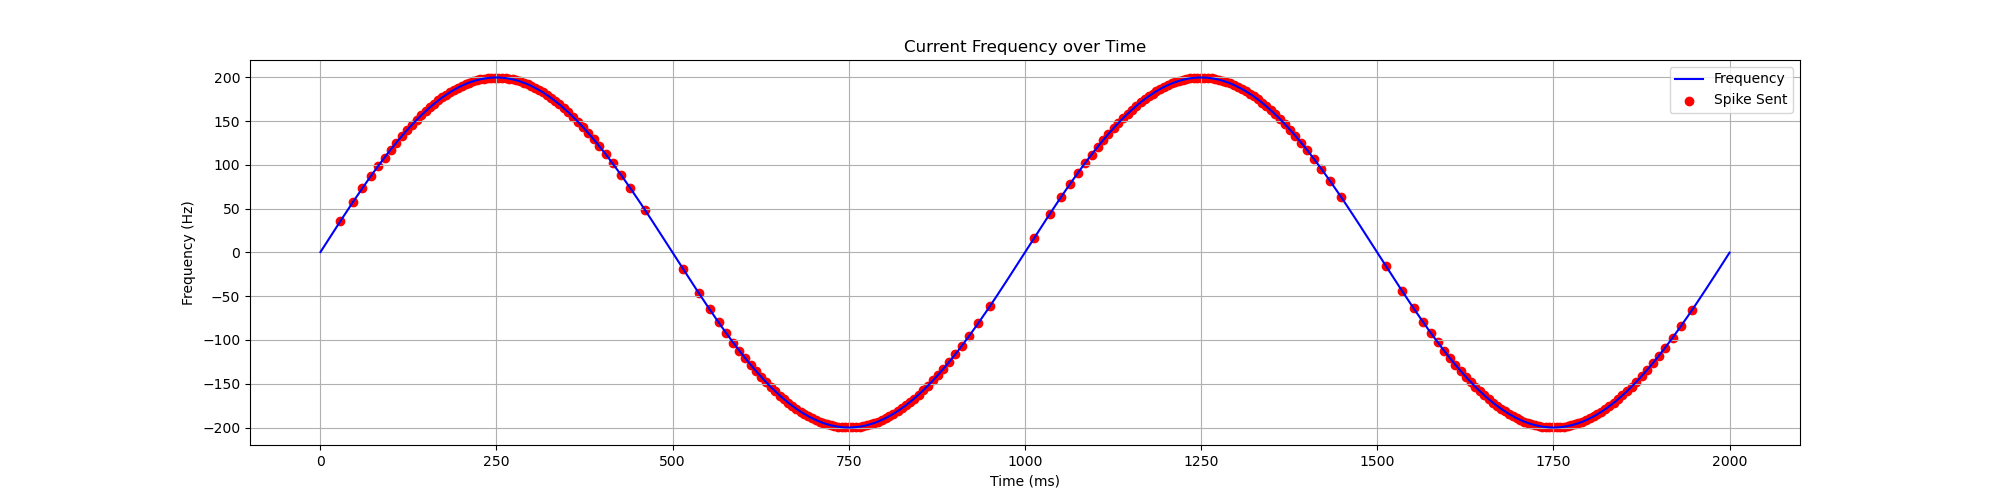

In [13]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV file
data = pd.read_csv('OscGenProcess.csv')

# Plot the data
plt.figure(figsize=(20, 5))
plt.plot(data['Time (ms)'], data['Frequency (Hz)'], label='Frequency', color='blue')
plt.scatter(data['Time (ms)'][data['Spike Sent'] == 1], data['Frequency (Hz)'][data['Spike Sent'] == 1], color='red', label='Spike Sent')

# Labeling the plot
plt.title('Current Frequency over Time')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid(True)
plt.show()


# Graphical Output from the `SineWaveGenerator.cpp` program. 

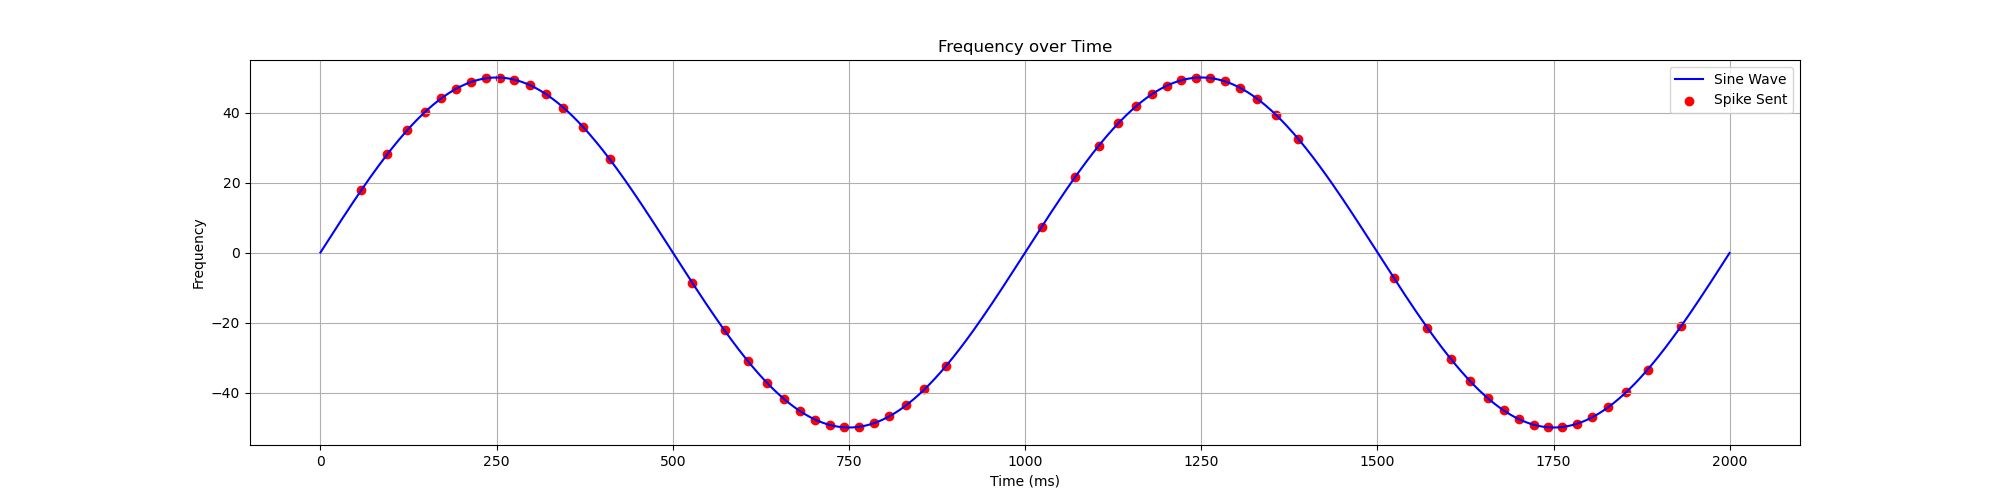

In [8]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported

# Load the data from CSV
data = pd.read_csv('sine_wave_data.csv')

# Plotting the sine wave
plt.figure(figsize=(20, 5))
plt.plot(data['Time (ms)'], data['Frequency (Hz)'], label='Sine Wave', color='blue')
plt.scatter(data['Time (ms)'][data['Spike Sent'] == 1], data['Frequency (Hz)'][data['Spike Sent'] == 1], color = 'red', label = 'Spike Sent')


plt.title('Frequency over Time')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
